***

<center><u><H1>Convolutional Neural Network: riconoscimento di immagini</H1></u></center>

***

***
# Il dataset

Per questo esempio di CNN, ricorriamo al dataset [CIFAR-10](https://www.cs.toronto.edu/%7Ekriz/cifar.html). Questo dataset, che può essere scaricato ricorrendo al modulo [dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) di tensorflow.keras, contiene 60000 immagini di dimensione 32x32 a colori raggruppate in 10 classi (6000 immagini per classe) divise in 10000 immagini per il test set e 50000 immagini per il training set. Le classi sono:
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

Le classi sono mutuamente esclusive e non vi sono sovrapposizioni.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers, models, Input

Per importare il dataset, possiamo direttamente accedere al modulo [keras.datasets](https://keras.io/api/datasets/) e caricarlo nel nostro codice:

In [2]:
from keras.datasets import cifar10

Abbiamo a tutti gli effetti importato un modulo. Per leggere i dati, già divisi in train e test set da Keras, è sufficiente utilizzare il metodo [load_data()](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data):

In [3]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

Il metodo load_data() fornisce in uscita una tupla di array NumPy con due elementi: il primo per il training set ed il secondo per il test set. Ogni elemento contiene le immagini e le label come array NumPy. Quindi train_images e test_images contengono le immagini, mentre train_labels e test_labels contengono un indice numerico che rappresenta la classe:

In [4]:
print(f"Train set: type = {type(train_images)}, shape = {train_images.shape}, data type = {train_images.dtype}")
print(f"Test set: type = {type(test_images)}, shape = {test_images.shape}, data type = {test_images.dtype}")

Train set: type = <class 'numpy.ndarray'>, shape = (50000, 32, 32, 3), data type = uint8
Test set: type = <class 'numpy.ndarray'>, shape = (10000, 32, 32, 3), data type = uint8


Possiamo notare come le label siano memorizzate come degli array: la seconda dimensione non è vuota, ma 1. Per accedere alle label, dovremo quindi usare una doppia indicizzazione:

In [5]:
print(train_labels[3])
print(train_labels[3][0])

[4]
4


Per comodità, creiamo una lista che contiene i nomi delle classi come elencati sopra:

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Verifichiamo che il dataset sia stato importato correttamente mostrando le prime 25 immagini (si ricorda che range parte di default da 0 ed esclude il valore indicato come stop):

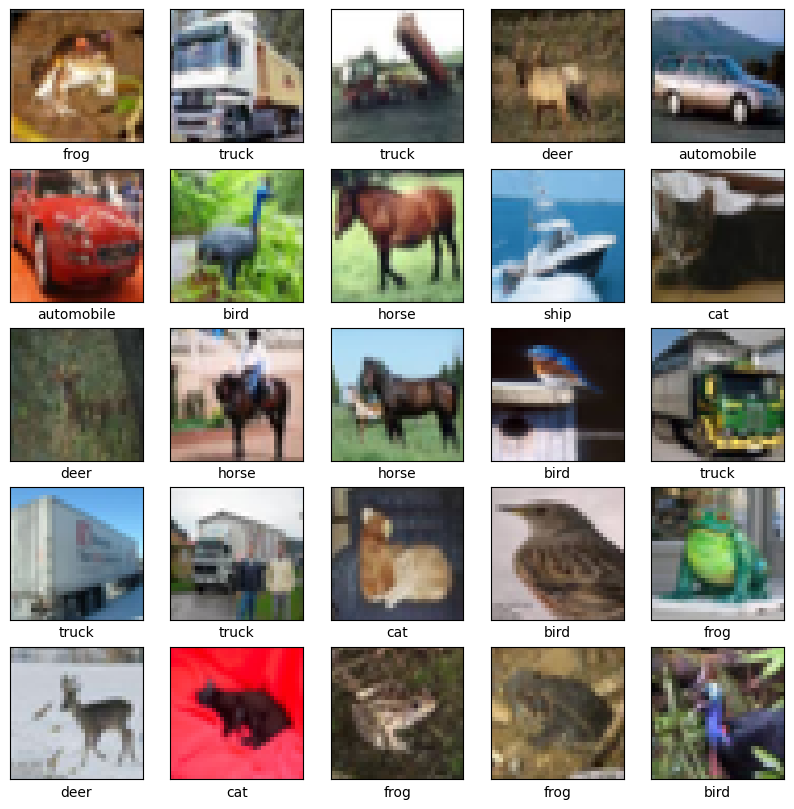

In [7]:
plt.figure(figsize=(10,10))
for fig_index in range(25):
    plt.subplot(5, 5, fig_index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[fig_index])
    plt.xlabel(class_names[train_labels[fig_index][0]])
plt.show()

Le immagini sono effettivamente piccole, $32\times 32$; questo dataset è relativamente vecchio (risale al 2008-2009) e questa limitata qualità giustifica il fatto che anche algoritmi molto avanzati non sono riusciti ad ottenere prestazioni eccezionali. Tuttavia, si tratta di un dataset ben conosciuto e comune, il che lo rende particolarmente adatto per sviluppare un primo esempio di CNN.

# Design della CNN

Andiamo ora a creare una CNN. Come abbiamo visto, una rete convoluzionale è composta da due sotto-reti:
- **Feature Learning**: una successione di layer convoluzionali con attivazione ReLU seguiti da layer di pooling;
- **Classification**: una ANN per la classificazione, di tipo fully connected.

## Feature Learning

Ricorriamo ai concetti visti per una rete neurale per creare la prima sotto-rete. In questo caso, avremo bisogno di due tipi di layer non ancora introdotti:
- [layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): crea un kernel convoluzionale;
- [layers.MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/): applica il downsampling in base alla tecnica di pooling indicata. 

Le immagini hanno dimensione $32\times 32$ e sono a colori, quindi l'input layer avrà una forma $32\times 32\times 3$. Questa volta, sfruttiamo l'approccio con la classe [Sequential](https://keras.io/guides/sequential_model/) perché è preferibile con una CNN per via della complessità dei legami tra layer.

Prima di creare la rete, dobbiamo ricordarci il feature scaling. In questo caso, abbiamo delle immagini come NumPy array con valori da 0 a 255: per non modificare le informazioni, andiamo a scalare i valori di un fattore 1/255. Questo può essere fatto operando direttamente su training e test set oppure inserendo un [Rescaling layer](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/). Prima di questo, esplicitiamo la dimensione dell'input tramite un oggetto [Input](https://keras.io/api/layers/core_layers/input/) di Keras:

In [8]:
my_seed = 0
tf.keras.utils.set_random_seed(my_seed)

In [9]:
model = models.Sequential()
model.add(Input(shape=(32, 32, 3)))
model.add(layers.Rescaling(scale=1./255))

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Iniziamo con la creazione della parte convoluzionale. Per il momento, creiamo 3 layer convoluzionali, ognuno seguito da un layer di pooling con la seguente configurazione:
- **strides**: il passo del filtraggio da indicare su entrambi gli assi in una tuple, con valore (1, 1) di default;
- **padding**: il padding da applicare ai bordi, in cui il default è **valid**;
- **activation**: usiamo una attivazione ReLU;
- **filters**: indica la dimensione dell'output, ovvero il numero di filtri applicati;
- **kernel_size**: dimensione del filtro, passata come una tuple o lista di interi.

Due osservazioni importanti:
- per la dimensione dei filtri da applicare, solitamente conviene ricorrere a multipli di 2 per maggiore efficienza computazionale;
- l'output layer deve avere tanti neuroni quante sono le classi da predire.

In [11]:
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))

In questo caso, abbiamo inserito 32 filtri nel primo layer convoluzionale e 64 negli altri due. I kernel per il filtraggio sono sempre $3\times 3$. Per quanto riguarda il pooling ([qui](https://keras.io/api/layers/pooling_layers/) una lista delle possibilità di Keras), stiamo lavorando con il massimo tramite il layer [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) (per quello basato sulla media, si ricorre al layer [AveragePooling2D](https://keras.io/api/layers/pooling_layers/average_pooling2d/)). Vediamo la rete ottenuta:

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

Possiamo notare come l'uscita di ogni layer Conv2D e MaxPooling2D è un tensore a tre dimensioni: altezza X larghezza X canali. Altezza e larghezza tendono a diminuire all'addentrarsi nella rete per via delle operazioni di filtragio, mentre i canali di uscita (il primo argomento nella creazione del layer) aumentano: la complessità rimane comunque sotto controllo in quanto stiamo riducendo le dimensioni delle immagini.

Come visto nella parte di teoria, la dimensione di un'immagine filtrata è $(\frac{N+2P-L}{S}+1)\times (\frac{N+2P-L}{S}+1)$. Nel nostro caso (guardando il primo layer convoluzionale) abbiamo $N=32$, $3$, $S=1$, $P=0$ da cui $30\times 30$. Nel secondo layer convoluzionale, si ha $N=15$ (a valle del pooling), $3$, $S=1$, $P=0$, quindi $13\times 13$ e così via.

## Classification

Passiamo ora alla ANN fully connected per la classificazione. L'ultimo tensore ha dimensione $2\times 2 \times 64$ e questo costituisce l'input della sotto-rete di classificazione. Per questa sotto-rete, introduciamo prima di tutto un layer [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) per convertire la matrice 3D in un array ad una dimensione; poi, inseriamo due layer di tipo [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). Il secondo, che è il nostro output layer, deve avere tanti nodi quante sono le classi da predire: 10.

In [13]:
model.add(layers.Flatten())
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

Come possiamo notare, il flattening ci porta ad un array con 256 elementi (2x2x64). Completiamo la rete:

In [14]:
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,418 (286.79 KB)

 Trainable params: 73,418 (286.79 KB)

 Non-trainable params: 0 (0.00 B)

Possiamo visualizzare il modello come già visto con le ANN:

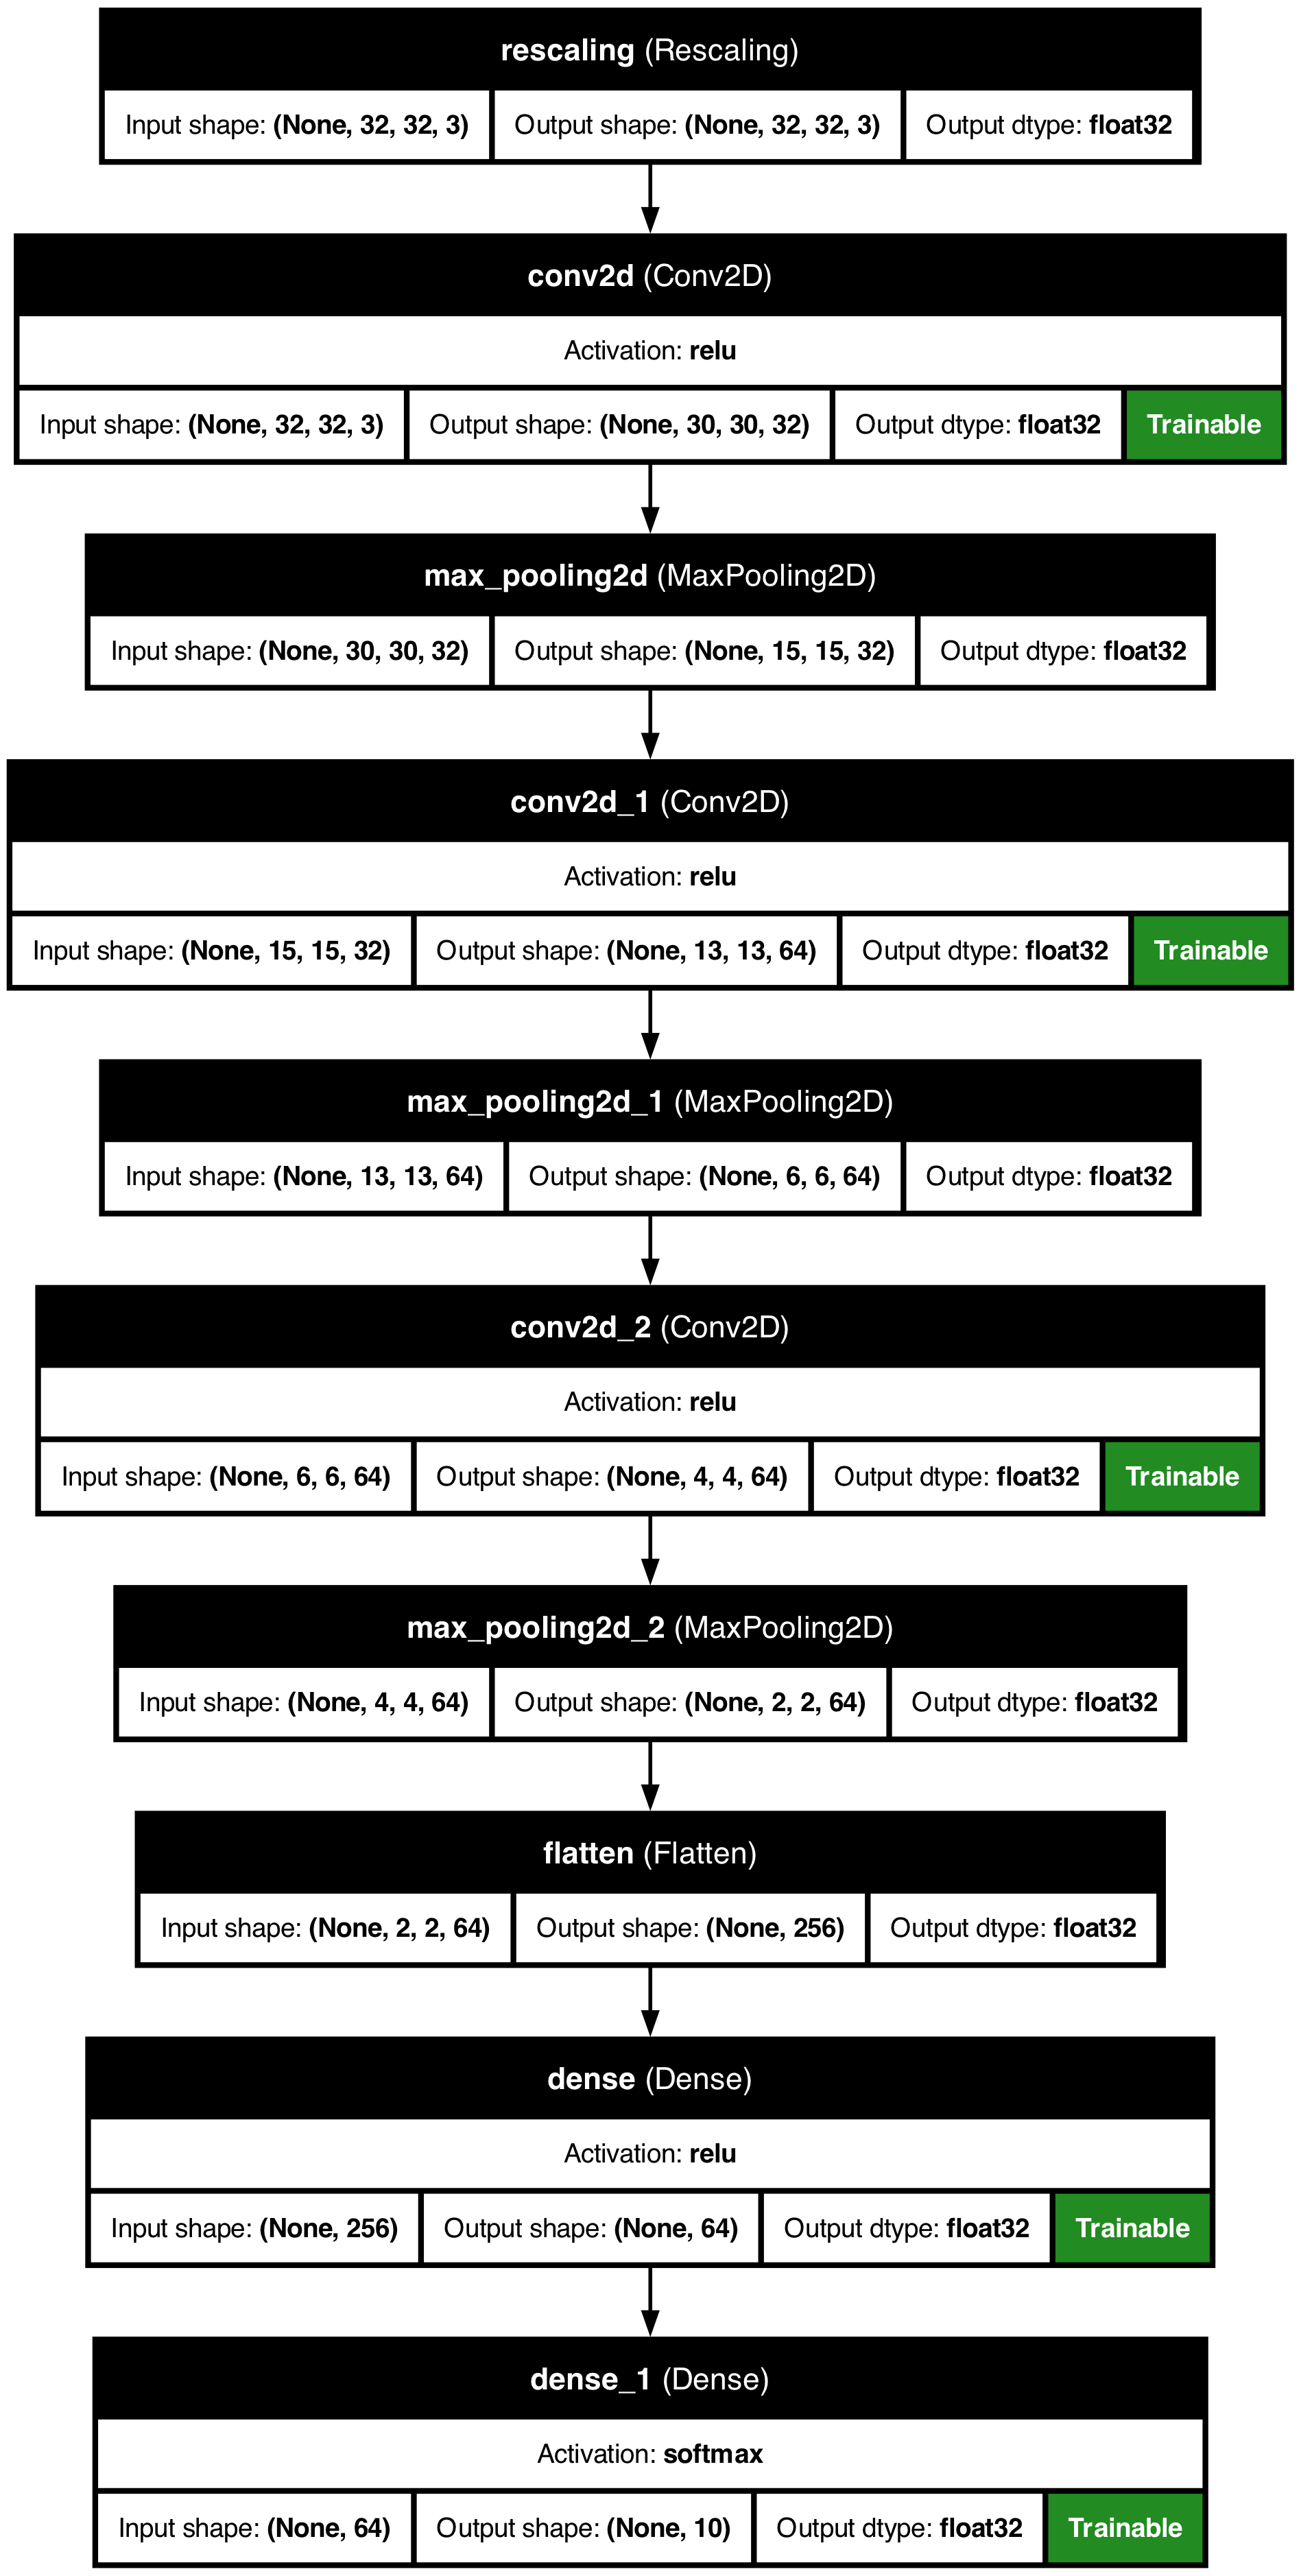

In [16]:
tf.keras.utils.plot_model(
    model,
    rankdir='TB',
    show_shapes=True,
    show_layer_names=True,
    show_dtype=True,
    show_layer_activations=True,
    show_trainable=True
)

## Addestramento e prestazioni

Possiamo ora addestrare la rete definendo la funzione di costo e l'ottimizzatore nel metodo compile(), come già fatto per le ANN, e poi chiamando il metodo fit() sul training set. Per quanto riguarda l'ottimizzazione:
- ricorriamo all'algoritmo Adam, una scelta sempre valida;
- come metrica, utilizziamo la **cross-entropy** (nota anche come log-loss, [link](https://www.datacamp.com/tutorial/the-cross-entropy-loss-function-in-machine-learning)): misura il numero medio di bit richiesti per identificare un evento da una distribuzione di probabilità $p$, ma ricorrendo ad uno schema/tecnica ottimizzata per una distribuzione di probabilità $q$. Viene utilizzata spesso in AI e ML per valutare le prestazioni di un modello quando l'obiettivo è la minimizzazione dell'errore tra la distribuzione di probabilità predetta e quella reale.

In Python, possiamo utilizzare un oggetto [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy).

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    train_labels,
    epochs=10, 
    validation_data=(test_images, test_labels)
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.3480 - loss: 1.7530 - val_accuracy: 0.5489 - val_loss: 1.2582
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.5715 - loss: 1.2024 - val_accuracy: 0.6002 - val_loss: 1.1245
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6383 - loss: 1.0366 - val_accuracy: 0.6376 - val_loss: 1.0309
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6733 - loss: 0.9362 - val_accuracy: 0.6564 - val_loss: 0.9807
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7020 - loss: 0.8628 - val_accuracy: 0.6682 - val_loss: 0.9559
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7201 - loss: 0.8065 - val_accuracy: 0.6735 - val_loss: 0.9363
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7337 - loss: 0.7587 - val_accuracy: 0.6855 - val_loss: 0.9289
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7508 -

<Axes: >

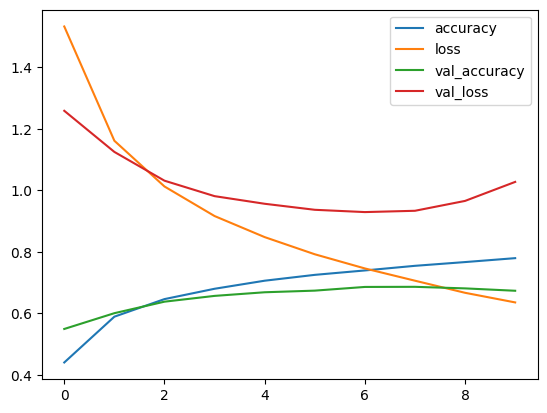

In [18]:
import pandas as pd
pd.DataFrame(history.history).plot()

Per valutare accuracy e loss sul test set, possiamo ricorrere al metodo [evaluate()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate), che appunto fornisce queste due metriche in una tuple:

In [19]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(test_acc)

0.6730999946594238


Per fare una predizione, prendiamo per comodità una delle immagini del test set e passiamola in ingresso:

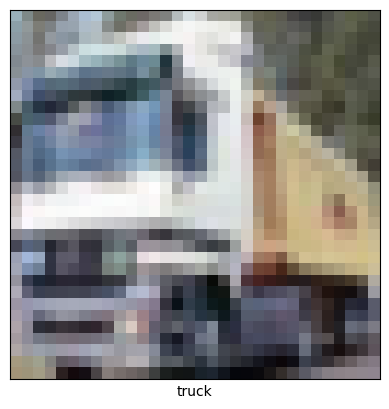

In [20]:
fig_index = 1
test_image = train_images[fig_index]
test_label = class_names[train_labels[fig_index][0]]
plt.imshow(test_image)
plt.xlabel(test_label)
plt.xticks([])
plt.yticks([])
plt.show()

In [21]:
test_image.shape

(32, 32, 3)

Il contenuto di test_image è un array NumPy di dimensione $32\times 32\times 3$, ma dobbiamo stare attenti: l'input layer vuole in ingresso un array con 4 dimensioni in cui in realtà la prima è vuota. Per fare questo, possiamo aggiungere una dimensione all'array NumPy tramite il metodo [expand_dims](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html):

In [22]:
import numpy as np
test_image = np.expand_dims(test_image, axis = 0)
test_image.shape

(1, 32, 32, 3)

Ora possiamo predire la label:

In [23]:
prediction = pd.DataFrame(model.predict(test_image, verbose=0), columns=class_names)
prediction.T

0
airplane    2.652102e-05
automobile  3.927066e-05
bird        1.192850e-05
cat         1.596656e-06
deer        6.780994e-09
dog         2.411088e-06
frog        1.742595e-10
horse       1.817094e-05
ship        2.218973e-06
truck       9.998978e-01

Otteniamo le probabilità di appartenenza ad ogni classe: prendiamo quella con la probabilità maggiore:

In [24]:
print(f"Predizione: {class_names[np.argmax(prediction)]}")

Predizione: truck


## Visualizzazione delle immagini filtrate

E' possibile ottenere i risultati intermedi di una rete neurale convoluzionale, ovvero le immagini filtrate a valle di un layer specifico. A tal fine, procediamo come segue: prima di tutto, recuperiamo i nomi dei layer accedendo all'attributo **layers** del modello allenato: 

In [25]:
model.layers

[<Rescaling name=rescaling, built=True>,
 <Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

Ora possiamo creare una "rete intermedia", ovvero una rete che parte dall'input layer di quella complessiva e ha come output layer il layer del quale vogliamo i risultati. Immaginiamo di essere interessati all'uscita del primo layer convoluzionale, costuito da $32$ immagini filtrate di dimensione $30\times 30$: 

In [26]:
intermediate_layer_model = models.Model(inputs=model.inputs, outputs=model.layers[1].output)
intermediate_layer_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

Prendiamo una figura di esempio da filtrare, come la seconda del training set (indice 1 di train_images):

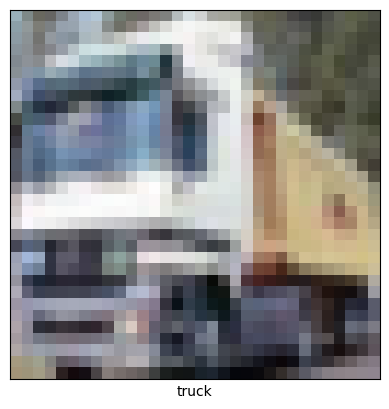

In [27]:
fig_index = 1
test_image = train_images[fig_index]
test_label = class_names[train_labels[fig_index][0]]
plt.imshow(test_image)
plt.xlabel(test_label)
plt.xticks([])
plt.yticks([])
plt.show()

In [28]:
test_image.shape

(32, 32, 3)

Il contenuto di test_image è un array NumPy di dimensione $32\times 32\times 3$, ma dobbiamo stare attenti: l'input layer vuole in ingresso un array con 4 dimensioni in cui in realtà la prima è vuota. Per fare questo, possiamo aggiungere una dimensione all'array NumPy tramite il metodo [expand_dims](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html):

In [29]:
import numpy as np
test_image = np.expand_dims(test_image, axis = 0)
test_image.shape

(1, 32, 32, 3)

Ora possiamo effettuare la predizione su questo input, ma utilizzando il modello "intermedio":

In [30]:
result = intermediate_layer_model.predict(test_image, verbose=0)
result.shape

/Users/alessandroguidotti/opt/anaconda3/envs/work/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


(1, 30, 30, 32)

Possiamo notare come abbiamo ottenuto effettivamente 32 immagini filtrate di dimensione $30\times 30$. Andiamo a vedere il grafico:

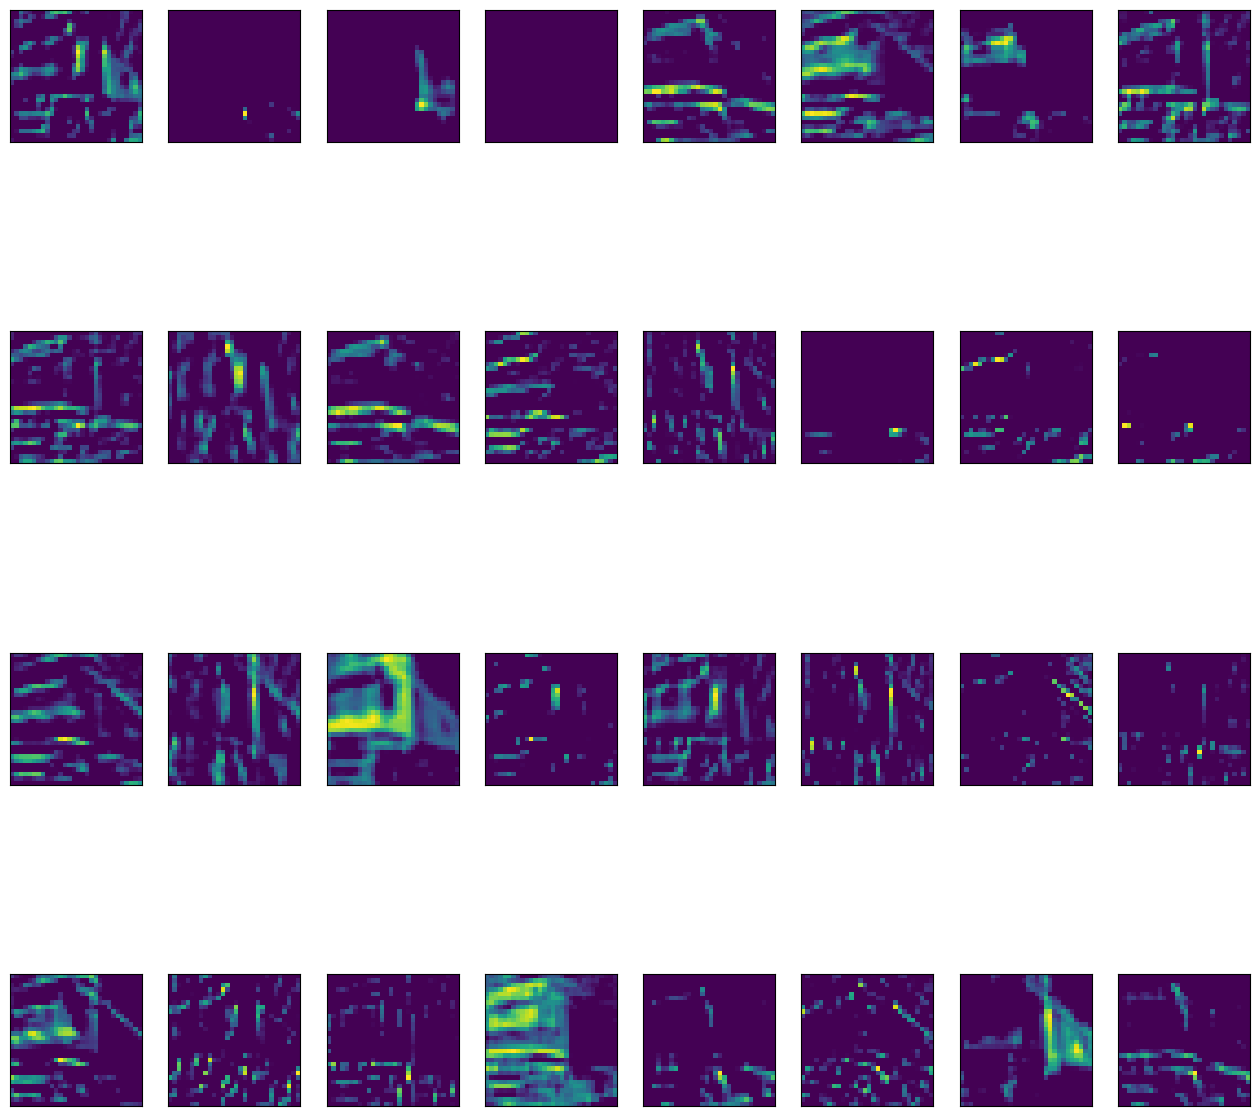

In [31]:
plt.figure(figsize=(16,16))
n_col = 8
n_row = 4
for filter_index in range(32):
    plt.subplot(n_row, n_col, filter_index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(result[:, :, :, filter_index]))
plt.show()

## Visualizzazione dei filtri

Possiamo anche visualizzare i filtri utilizzati in uno specifico layer convoluzionale. Per farlo, recuperiamo appunto filtri e bias dal layer desiderato tramite il metodo [get_weights()](https://keras.io/api/layers/base_layer/):

In [32]:
filters, biases = model.layers[1].get_weights()

In [33]:
print(f"Filtri: {type(filters)}, shape: {filters.shape}")
print(f"Bias: {type(biases)}, shape: {biases.shape}")

Filtri: <class 'numpy.ndarray'>, shape: (3, 3, 3, 32)
Bias: <class 'numpy.ndarray'>, shape: (32,)


Normalizziamo i valori dei filtri per averli compresi tra 0 e 1, e mostrarli come gradazione di grigio:

In [34]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

E ora possiamo ottenere le immagini dei filtri. Per comodità, rappresentiamo solo quelli su uno dei canali, ad esempio il rosso (indice 0 della terza dimensione):

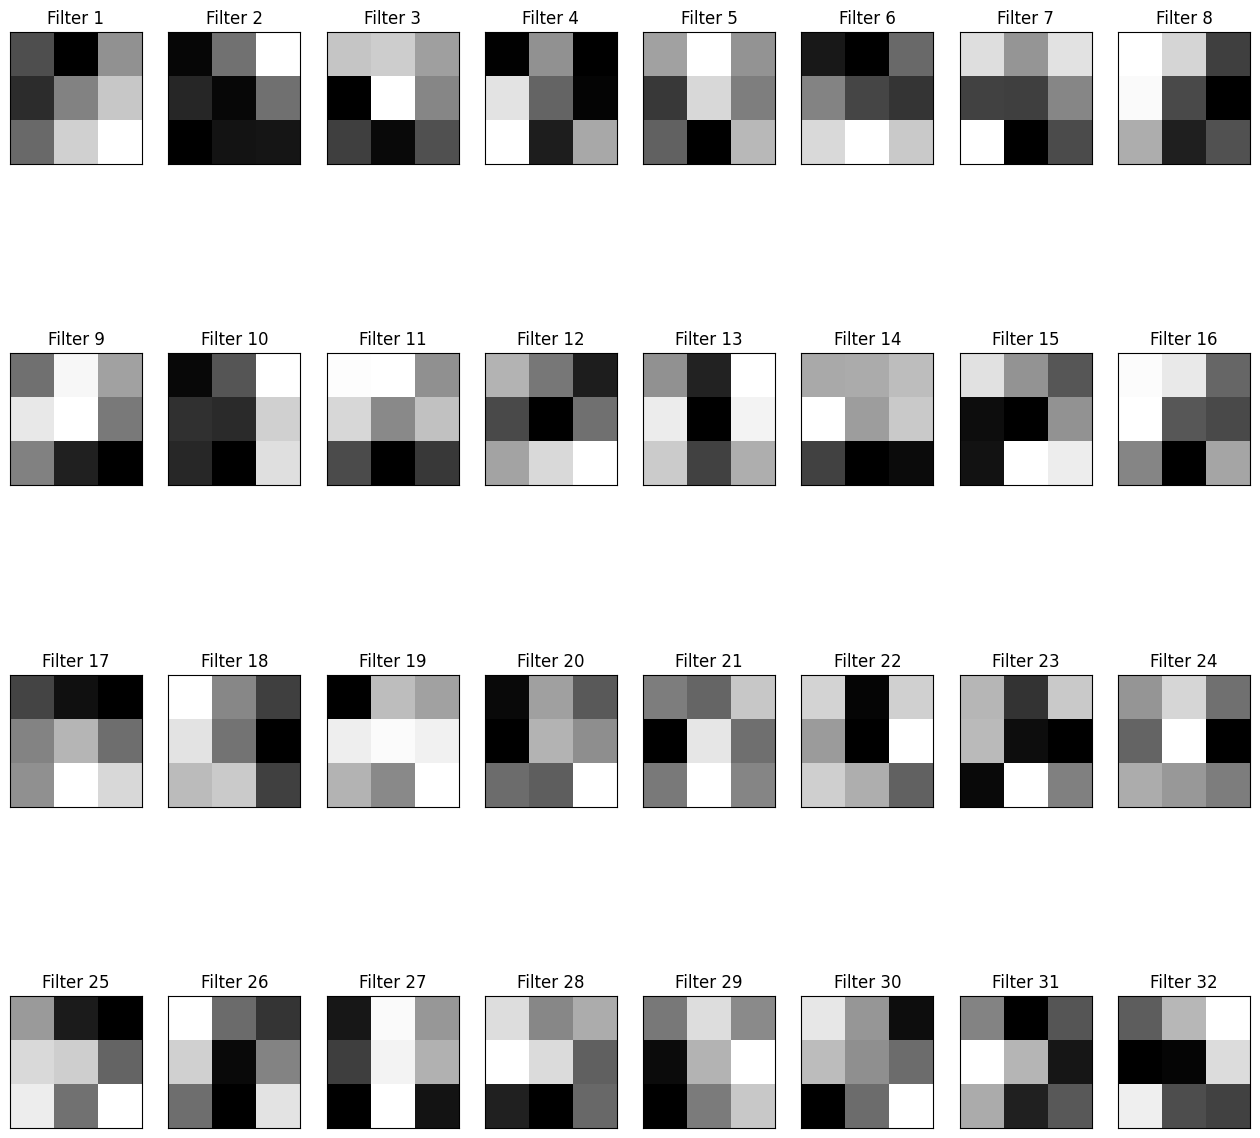

In [35]:
channel_index = 0
n_col = 8
n_row = 4
plt.figure(figsize=(16,16))
for filter_index in range(32):
    plt.subplot(n_row, n_col, filter_index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(f"Filter {filter_index+1}")
    plt.imshow(np.squeeze(filters[:, :, channel_index, filter_index]), cmap='gray')
plt.show()

# Design alternativi della rete

Proviamo altre soluzioni per la nostra rete convoluzionale. Ad esempio, potremmo valutare di diminuire il numero di layer convoluzionali o aumentare/diminuire quello dei canali dei filtri e vedere l'effetto sulle predizioni. Non aumentiamo il numero di layer convoluzionali in quanto inserendone un altro e con il max pooling implementato, ci ritroveremmo con una matrice di dimensioni nulle alla fine per via delle dimensioni iniziali dell'immagine.

## Numero di Convolutional layer

Proviamo prima con un layer convoluzionale in meno poi con uno in più. Nel primo caso, andiamo a rimuovere l'ultimo layer convoluzionale.

Prima di tutto, re-inizializziamo i seed:

In [36]:
tf.keras.utils.set_random_seed(my_seed)

Ora creiamo la rete come fatto in precedenza. Prima la Feature Learning:

In [37]:
model = models.Sequential()
model.add(Input(shape=(32, 32, 3)))
model.add(layers.Rescaling(scale=1./255))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,562 (654.54 KB)

 Trainable params: 167,562 (654.54 KB)

 Non-trainable params: 0 (0.00 B)

Addestriamo la rete e valutiamo le prestazioni:

In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    train_labels,
    epochs=10, 
    validation_data=(test_images, test_labels)
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.3892 - loss: 1.6814 - val_accuracy: 0.5558 - val_loss: 1.2647
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5896 - loss: 1.1620 - val_accuracy: 0.6133 - val_loss: 1.1096
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.6481 - loss: 1.0002 - val_accuracy: 0.6422 - val_loss: 1.0467
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.6857 - loss: 0.9038 - val_accuracy: 0.6580 - val_loss: 1.0147
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7112 - loss: 0.8332 - val_accuracy: 0.6628 - val_loss: 1.0062
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7308 - loss: 0.7737 - val_accuracy: 0.6766 - val_loss: 0.9774
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7481 - loss: 0.7247 - val_accuracy: 0.6799 - val_loss: 0.9813
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7634 -

<Axes: >

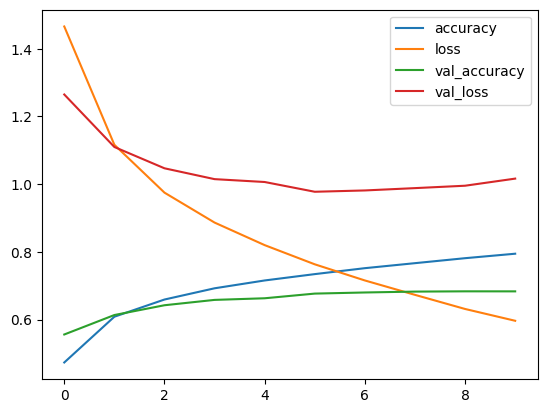

In [39]:
pd.DataFrame(history.history).plot()

In [40]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

313/313 - 1s - 4ms/step - accuracy: 0.6832 - loss: 1.0162
0.6832000017166138


La prestazione è legermente migliorata, oltretutto con una rete un po' meno complessa.

## Numero di filtri

Ripetiamo prima la rete iniziale, cambiando il numero di filtri utilizzati. Prima diminuiamoli:

In [41]:
tf.keras.utils.set_random_seed(my_seed)

In [42]:
model = models.Sequential()
model.add(Input(shape=(32, 32, 3)))
model.add(layers.Rescaling(scale=1./255))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,682 (158.91 KB)

 Trainable params: 40,682 (158.91 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    train_labels,
    epochs=10, 
    validation_data=(test_images, test_labels)
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.3096 - loss: 1.8521 - val_accuracy: 0.5106 - val_loss: 1.3695
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5310 - loss: 1.3057 - val_accuracy: 0.5830 - val_loss: 1.1921
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5915 - loss: 1.1554 - val_accuracy: 0.6093 - val_loss: 1.1243
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6244 - loss: 1.0677 - val_accuracy: 0.6238 - val_loss: 1.0913
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6482 - loss: 1.0053 - val_accuracy: 0.6325 - val_loss: 1.0582
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6671 - loss: 0.9568 - val_accuracy: 0.6426 - val_loss: 1.0395
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6826 - loss: 0.9130 - val_accuracy: 0.6475 - val_loss: 1.0236
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6939 - loss: 0

<Axes: >

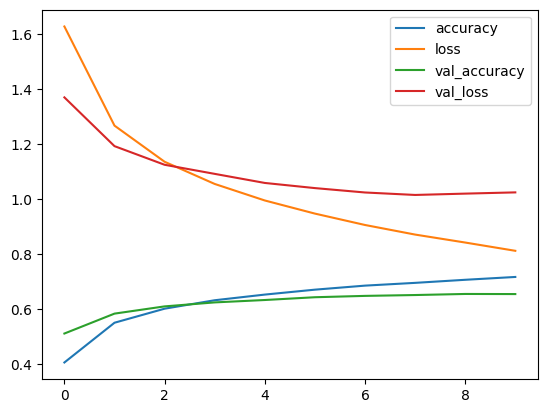

In [44]:
pd.DataFrame(history.history).plot()

In [45]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

313/313 - 1s - 3ms/step - accuracy: 0.6541 - loss: 1.0239
0.6541000008583069


Le prestazioni sono leggermente peggiorate. Ora andiamo ad incrementarli:

In [46]:
tf.keras.utils.set_random_seed(my_seed)

In [47]:
model = models.Sequential()
model.add(Input(shape=(32, 32, 3)))
model.add(layers.Rescaling(scale=1./255))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,714 (1002.79 KB)

 Trainable params: 256,714 (1002.79 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    train_labels,
    epochs=10, 
    validation_data=(test_images, test_labels)
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.3726 - loss: 1.7039 - val_accuracy: 0.5848 - val_loss: 1.1667
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.6051 - loss: 1.1184 - val_accuracy: 0.6463 - val_loss: 1.0160
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.6782 - loss: 0.9258 - val_accuracy: 0.6761 - val_loss: 0.9474
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.7222 - loss: 0.8014 - val_accuracy: 0.6719 - val_loss: 0.9824
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.7508 - loss: 0.7158 - val_accuracy: 0.6801 - val_loss: 0.9700
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.7753 - loss: 0.6422 - val_accuracy: 0.6803 - val_loss: 0.9916
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.7986 - loss: 0.5809 - val_accuracy: 0.7002 - val_loss: 0.9770
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.8181 -

<Axes: >

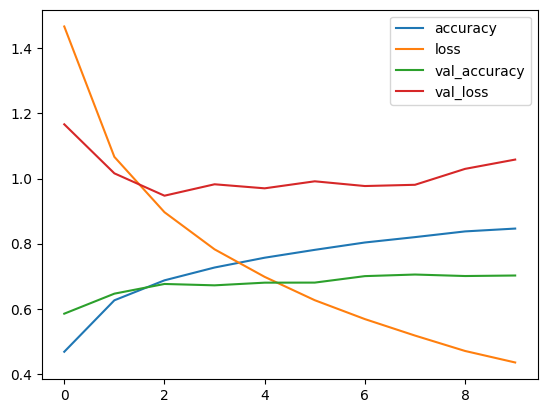

In [49]:
pd.DataFrame(history.history).plot()

In [50]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(test_acc)

313/313 - 3s - 8ms/step - accuracy: 0.7021 - loss: 1.0584
0.7020999789237976


Le prestazioni sono migliorate! Chiaramente è possibile valutare molte altre architetture della rete, andando anche a modificare quella di classificazione e ricorrendo a dei layer non visti a lezione, come quelli di dropout o regolarizzazione. Tuttavia, con un dataset avente delle immagini di scarsa qualità, un'accuratezza del 70.2% è già un buon risultato.